# behley2019iccv

> Module to handle loading, preprocessing and postprocessing of the data from [SemanticKITTI: A Dataset for Semantic Scene Understanding of LiDAR Sequences](https://arxiv.org/pdf/1904.01416).

In [ ]:
#| default_exp behley2019iccv

In [ ]:
#| export
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from lightning import LightningDataModule
from torchvision.transforms import v2

## [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api)

This is an adaptation of the code from the semantic-kitti-api as a pytorch [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
#| export
class SemanticKITTIDataset(Dataset):
    "Load the SemanticKITTI data in a pytorch Dataset object."
    def __init__(self, data_path, is_train=True, transform=None):
        data_path = Path(data_path)
        yaml_path = data_path/'semantic-kitti.yaml'
        self.velodyne_path = data_path/'data_odometry_velodyne/dataset/sequences'
        self.labels_path = data_path/'data_odometry_labels/dataset/sequences'
        
        velodyne_fns = []
        if is_train: 
            query = '*0[0-9]/velodyne/*.bin'
            velodyne_fns += list(self.velodyne_path.rglob(query))
            query = '*10/velodyne/*.bin'
            velodyne_fns += list(self.velodyne_path.rglob(query))
        else:
            query = '*[12][1-9]/velodyne/*.bin'
            velodyne_fns += list(self.velodyne_path.rglob(query))
            query = '*20/velodyne/*.bin'
            velodyne_fns += list(self.velodyne_path.rglob(query))
        
        self.frame_ids = [fn.stem for fn in velodyne_fns]
        self.frame_sequences = [fn.parts[-3] for fn in velodyne_fns]
        
        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)
        
        self.labels_dict = metadata.get('labels', {})
        
        self.learning_map = metadata.get('learning_map', {})
        max_key = sorted(self.learning_map.keys())[-1]
        self.learning_map_np = np.zeros((max_key+1,), dtype=int)
        for k, v in self.learning_map.items():
            self.learning_map_np[k] = v
        
        self.learning_map_inv = metadata.get('learning_map_inv', {})
        self.learning_map_inv_np = np.zeros((len(self.learning_map_inv),))
        for k, v in self.learning_map_inv.items():
            self.learning_map_inv_np[k] = v
        
        self.color_map_bgr = metadata.get('color_map', {})
        max_key = sorted(self.color_map_bgr.keys())[-1]
        self.color_map_rgb_np = np.zeros((max_key+1, 3))
        for k, v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform
        self.is_train = is_train
    
    def learning_remap(self, remapping_rules):
        new_map_np = np.zeros_like(self.learning_map_np, dtype=int)
        max_key = sorted(remapping_rules.values())[-1]
        new_map_inv_np = np.zeros((max_key+1,), dtype=int)
        for k, v in remapping_rules.items():
            new_map_np[self.learning_map_np == k] = v
            if new_map_inv_np[v] == 0:
                new_map_inv_np[v] = self.learning_map_inv_np[k]
        self.learning_map_np = new_map_np
        self.learning_map_inv_np = new_map_inv_np
    
    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_sequence = self.frame_sequences[idx]
        
        frame_path = self.velodyne_path/frame_sequence/'velodyne'/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
        
        label = None
        if self.is_train:
            label_path = self.labels_path/frame_sequence/'labels'/(frame_id + '.label')
            with open(label_path, 'rb') as f:
                label = np.fromfile(f, dtype=np.uint32)
                label = label & 0xFFFF
            label = self.learning_map_np[label]
        
        mask = None
        if self.transform:
            frame, label, mask = self.transform(frame, label)
        
        return frame, label, mask

To use it, first download and extract the *data_odometry_velodyne* and *data_odometry_labels* folders from the provided links on their [website](http://semantic-kitti.org/dataset.html#download) into a folder called *data*, at the root of your workspace. Then, download the [yaml file](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti.yaml) with the metadata from the [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api) to the same folder. Lastly, use the following code to get the training data in its original format:

In [ ]:
#| eval: false
data_path = '/workspace/data'
ds = SemanticKITTIDataset(data_path)
frame, label, mask = ds[128]
len(ds)

23201

Without any transform set, the data is simply read into numpy arrays and mask is set to **None**.

In [ ]:
#| eval: false
frame, frame.shape

(array([[68.421135 ,  0.7897667,  2.5229597,  0.       ],
        [68.50563  ,  1.0067025,  2.5259488,  0.       ],
        [68.56113  ,  1.2226388,  2.5279377,  0.       ],
        ...,
        [ 3.8224514, -1.4165174, -1.7585769,  0.34     ],
        [ 3.8349648, -1.4085199, -1.7635802,  0.33     ],
        [ 3.8374305, -1.395524 , -1.7625839,  0.       ]], dtype=float32),
 (120210, 4))

In [ ]:
#| eval: false
label, label.shape, label.dtype, set(label)

(array([0, 0, 0, ..., 9, 9, 9]),
 (120210,),
 dtype('int64'),
 {0, 1, 4, 5, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19})

In [ ]:
#| eval: false
mask == None

True

## Lidar Range Image Projections

One of the most efficient and performant ways to process Lidar point clouds is with the idea of range images introduced by the paper [Range-Image: Incorporating sensor topology for LiDAR point cloud processing](https://hal.science/hal-01756975/document) From the best of our knowledge there are two ways to compute such images in the literature:

- Sperical/cylindrical projections (some papers that use this method: [SqueezeSeg: Convolutional Neural Nets with Recurrent CRF for Real-Time Road-Object Segmentation from 3D LiDAR Point Cloud](https://arxiv.org/pdf/1710.07368), [RIU-Net: Embarrassingly simple semantic segmentation
of 3D LiDAR point cloud](https://arxiv.org/pdf/1905.08748), etc.)

- Scan Unfolding projection (some papers that use this method: [Scan-based Semantic Segmentation of LiDAR Point Clouds: An Experimental Study](https://arxiv.org/pdf/2004.11803), [EfficientLPS: Efficient LiDAR Panoptic
Segmentation](https://arxiv.org/pdf/2102.08009))

In [ ]:
#| export
class SphericalProjection:
    "Calculate yaw and pitch angles for each point and quantize these angles into image grid."
    def __init__(self, fov_up_deg, fov_down_deg, W, H):
        self.fov_up_rad = (fov_up_deg/180.)*np.pi
        self.fov_down_rad = (fov_down_deg/180.)*np.pi
        self.fov_rad = self.fov_up_rad - self.fov_down_rad
        self.W = W
        self.H = H
    
    def get_xy_projections(self, scan_xyz, depth):
        # get angles of all points
        yaw = np.arctan2(scan_xyz[:,1], scan_xyz[:,0])
        pitch = np.arcsin(scan_xyz[:,2] / depth)
        
        # get projections in image coords (between [0.0, 1.0])
        proj_x = 0.5*(1. + yaw/np.pi)
        proj_y = (self.fov_up_rad - pitch)/self.fov_rad

        # just making sure nothing wierd happened with the np.arctan2 function
        assert proj_x.min() >= 0.
        assert proj_x.max() <= 1.
        # if fov_up or fov_dow are too small, these will raise an error
        assert proj_y.min() >= 0.
        assert proj_y.min() <= 1.
        
        # scale to image size using angular resolution (between [0.0, W/H])
        proj_x *= self.W
        proj_y *= self.H
        
        # round and clamp to use as indices (between [0, W/H - 1])
        proj_x = np.floor(proj_x)
        proj_x = np.clip(proj_x, 0, self.W - 1).astype(int)
        
        proj_y = np.floor(proj_y)
        proj_y = np.clip(proj_y, 0, self.H - 1).astype(int)
        
        return proj_x, proj_y

The following images from the Medium article [Spherical Projection for Point Clouds](https://towardsdatascience.com/spherical-projection-for-point-clouds-56a2fc258e6c) illustrate the process in the spherical projection calculation:

![Figure 1: Topology of the Lidar sensor. In the image, the author shows an example with a Lidar with 16 lines.](https://miro.medium.com/v2/resize:fit:828/format:webp/1*FEg6D6V_CzlSaDsCxXzfLg.png)

![Figure 2: Spherical coordinate system and its relation to the projection image grid.](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*dwx4RdGRknJUk415dZoILw.png)

In [ ]:
#| export
class UnfoldingProjection:
    "Assume the points are sorted in increasing yaw order and line number."
    def __init__(self, W, H, eps=1e-5):
        self.W = W
        self.H = H
        self.eps = eps
    
    def get_xy_projections(self, scan_xyz, depth):
        # get yaw angles of all points
        yaw = np.arctan2(scan_xyz[:,1], scan_xyz[:,0])
        
        # rectify yaw value to be between ]0, 2*pi[
        yaw[yaw < 0] += 2.*np.pi
        
        # scale to image size
        proj_x  = np.floor(self.W*0.5*yaw/np.pi).astype(int)
        
        # just making sure nothing wierd happened with the np.arctan2 or the np.floor functions
        assert proj_x.min() >= 0
        assert proj_x.max() < self.W
        
        # find discontinuities ("jumps") from scan completing cycle
        jump = yaw[1:] - yaw[:-1] < -np.pi
        jump = np.concatenate((np.zeros(1), jump))
        
        # every jump indicates a new scan row
        proj_y = jump.cumsum().astype(int)
        
        # for debugging only
        if proj_y.max() > self.H - 1:
            print(proj_y.max())
        assert proj_y.max() <= self.H - 1
        
        return proj_x, proj_y

If the points are sorted in increasing yaw order and line number (which is the case in the SemanticKITTI dataset), then the projection lines can be found by making sure that discontinuities in yaw sequences come from scan completing cycles. That way, we can find these discontinuities and then quantize the yaw angles in the projection lines so they can be assigned to each pixel in the image grid.

To make sure the discontinuites happen from one scan line to another, we take into consideration that the vehicle used in the SemanticKITTI dataset has the following [sensor configuration](https://www.cvlibs.net/datasets/kitti/setup.php):

![](https://www.cvlibs.net/datasets/kitti/images/passat_sensors_920.png)

We also know that the Lidar sensor rotates its lasers in a  counter-clockwise direction and that a lidar frame starts and finishes when the lasers cross the *x axis*.
Therefore, we calculate the yaw angles with the *np.arctan2* function and then add $2\pi$ to the ones that are negative. The plot below, shows this trick on toy example data:

In [ ]:
#| eval: false
from matplotlib import pyplot as plt

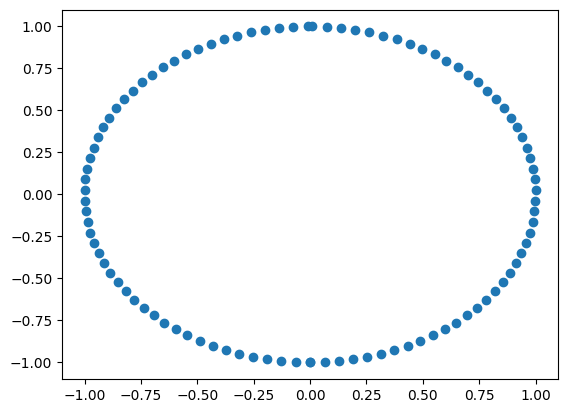

In [ ]:
#| eval: false
fake_yaw_raw_data = np.concatenate((np.linspace(0.01,np.pi), np.linspace(-np.pi, -0.01)))
fake_data_x = np.cos(fake_yaw_raw_data)
fake_data_y = np.sin(fake_yaw_raw_data)

plt.scatter(fake_data_y, fake_data_x);

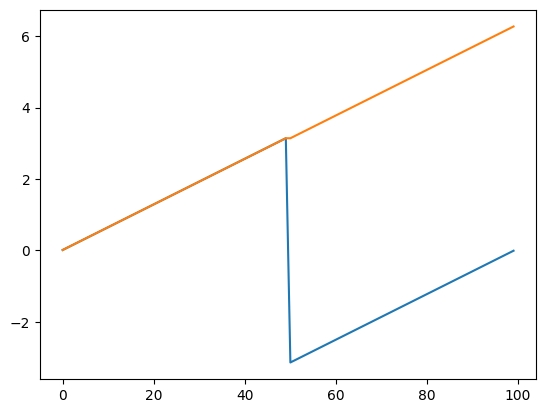

In [ ]:
#| eval: false
fake_yaw = np.arctan2(fake_data_y, fake_data_x)
fake_yaw_corrected = np.arctan2(fake_data_y, fake_data_x)
fake_yaw_corrected[fake_yaw_corrected < 0] += 2.*np.pi
plt.plot(fake_yaw)
plt.plot(fake_yaw_corrected);

From this trick, we can simply detect the end of each projection line by checking when the diference between adjacent angles is smaller than some threshold. After some experimentation with different samples, a threshold of $-\pi$ seems to robust even if there are some missing readings from the lidar.

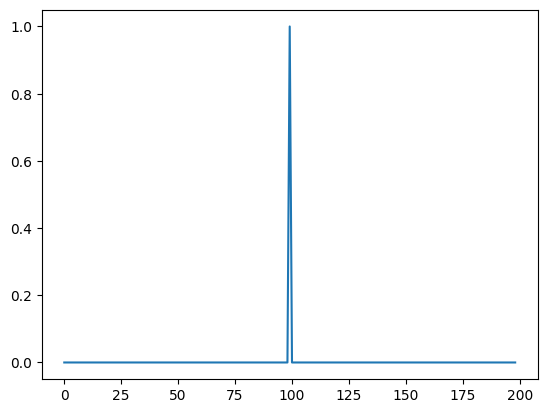

In [ ]:
#| eval: false
two_lines = np.concatenate((fake_yaw_corrected, fake_yaw_corrected))
jump = two_lines[1:] - two_lines[:-1] < -np.pi
plt.plot(jump);

In [ ]:
#| export
class ProjectionTransform(nn.Module):
    "Pytorch transform that turns a point cloud frame and its respective label into images in given projection style."
    def __init__(self, projection):
        super().__init__()
        self.projection = projection
        self.W = projection.W
        self.H = projection.H
        
    def forward(self, frame, label):
        # get point_cloud components
        scan_xyz = frame[:,:3]
        reflectance = frame[:, 3]

        assert reflectance.max() <= 1.
        assert reflectance.min() >= 0.

        # get depths of all points
        depth = np.linalg.norm(scan_xyz, 2, axis=1)

        # get projections
        proj_x, proj_y = self.projection.get_xy_projections(scan_xyz, depth)
        
        # order in decreasing depth
        order = np.argsort(depth)[::-1]
        info_list = [
            scan_xyz,
            reflectance[..., np.newaxis],
            depth[..., np.newaxis]
        ]
        if label is not None:
            info_list += [label[..., np.newaxis]]
            
        scan_info = np.concatenate(info_list, axis=-1)
        scan_info = scan_info[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]
        
        # setup the image tensor
        projections_img = np.zeros((self.H, self.W, 2+len(info_list)))
        projections_img[:,:,-1] -= 1 # this helps to identify points in the projection with no lidar readings
        projections_img[proj_y, proj_x] = scan_info
        
        if label is not None:
            # frame image
            frame_img = projections_img[:,:,:-1]
            # label image
            label_img = projections_img[:,:,-1].astype(int)
        else:
            frame_img = projections_img
            label_img = None
        # mask image
        mask_img = projections_img[:,:,-1]>=0
        
        return frame_img, label_img, mask_img

With one of the projection algorithms described previously, we can construct a *ProjectionTransform* object that can be used with the *SemanticKITTIDataset*. Here is an example on how to use it:

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = ProjectionTransform(proj)
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[128]

As we can see below, the data is still returned as numpy arrays, but their shapes have changed as follows:

- frame: from a sequence of 4D float vectors (i.e. x, y, z, reflectance) to an image of HxW resolution with 5 channels with float numbers (i.e. x, y, z, reflectance, depth);
- label: from a sequence of integers to an image of HxW resolution with a single channel with an integer;
- mask: from **None** to an image of HxW resolution with a single channel with booleans.

There are a lot of pixels in these projection images that have no corresponding lidar readings to be projected. Hence, these pixels were filled with:

- in frame_img: 0.
- in label_img: -1

The mask image provides a convenient boolean mask to easily identify pixels with valid lidar readings marked as 'True' and pixels with no lidar readings marked as 'False'.

In [ ]:
#| eval: false
frame_img[:2], frame_img.shape, frame_img.dtype

(array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]),
 (64, 1024, 5),
 dtype('float64'))

In [ ]:
#| eval: false
label_img[:2], label_img.shape, label_img.dtype, set(label_img.flatten())

(array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]),
 (64, 1024),
 dtype('int64'),
 {-1, 0, 1, 4, 5, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19})

In [ ]:
#| eval: false
mask_img[:2], mask_img.shape, mask_img.dtype

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 (64, 1024),
 dtype('bool'))

In [ ]:
#| export
class ProjectionVizTransform(nn.Module):
    "Pytorch transform to preprocess projection images for proper visualization."
    def __init__(self, color_map_rgb_np, learning_map_inv_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np
        self.learning_map_inv_np = learning_map_inv_np
    
    def scale(self, img, min_value, max_value):
        assert img.max() <= max_value
        assert img.min() >= min_value
        assert max_value > min_value
        
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)
    
    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            r = self.scale(frame_img[:,:,3], 0., 1.)
            d = self.scale(frame_img[:,:,4], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, r, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)
        
        return normalized_frame_img, colored_label_img, mask_img

In order to plot comparable visualizations of the projections, we need to standardize the scale of the float channels from the frame projection and map the label integers to their corresponding RGB color defined in the *color_map* dict from the [yaml file](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti.yaml) that was downloaded before. After some experimentation with several samples from the entire dataset, the hardcoded scale values in the *ProjectionVizTransform.forward* method seemed to work reasonably well.

Here is an example on how to use and compose the previous transforms with the *torchvision.transforms.v2* module, and then visualize the resulting images with the *matplolib.pyplot* module:

In [ ]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

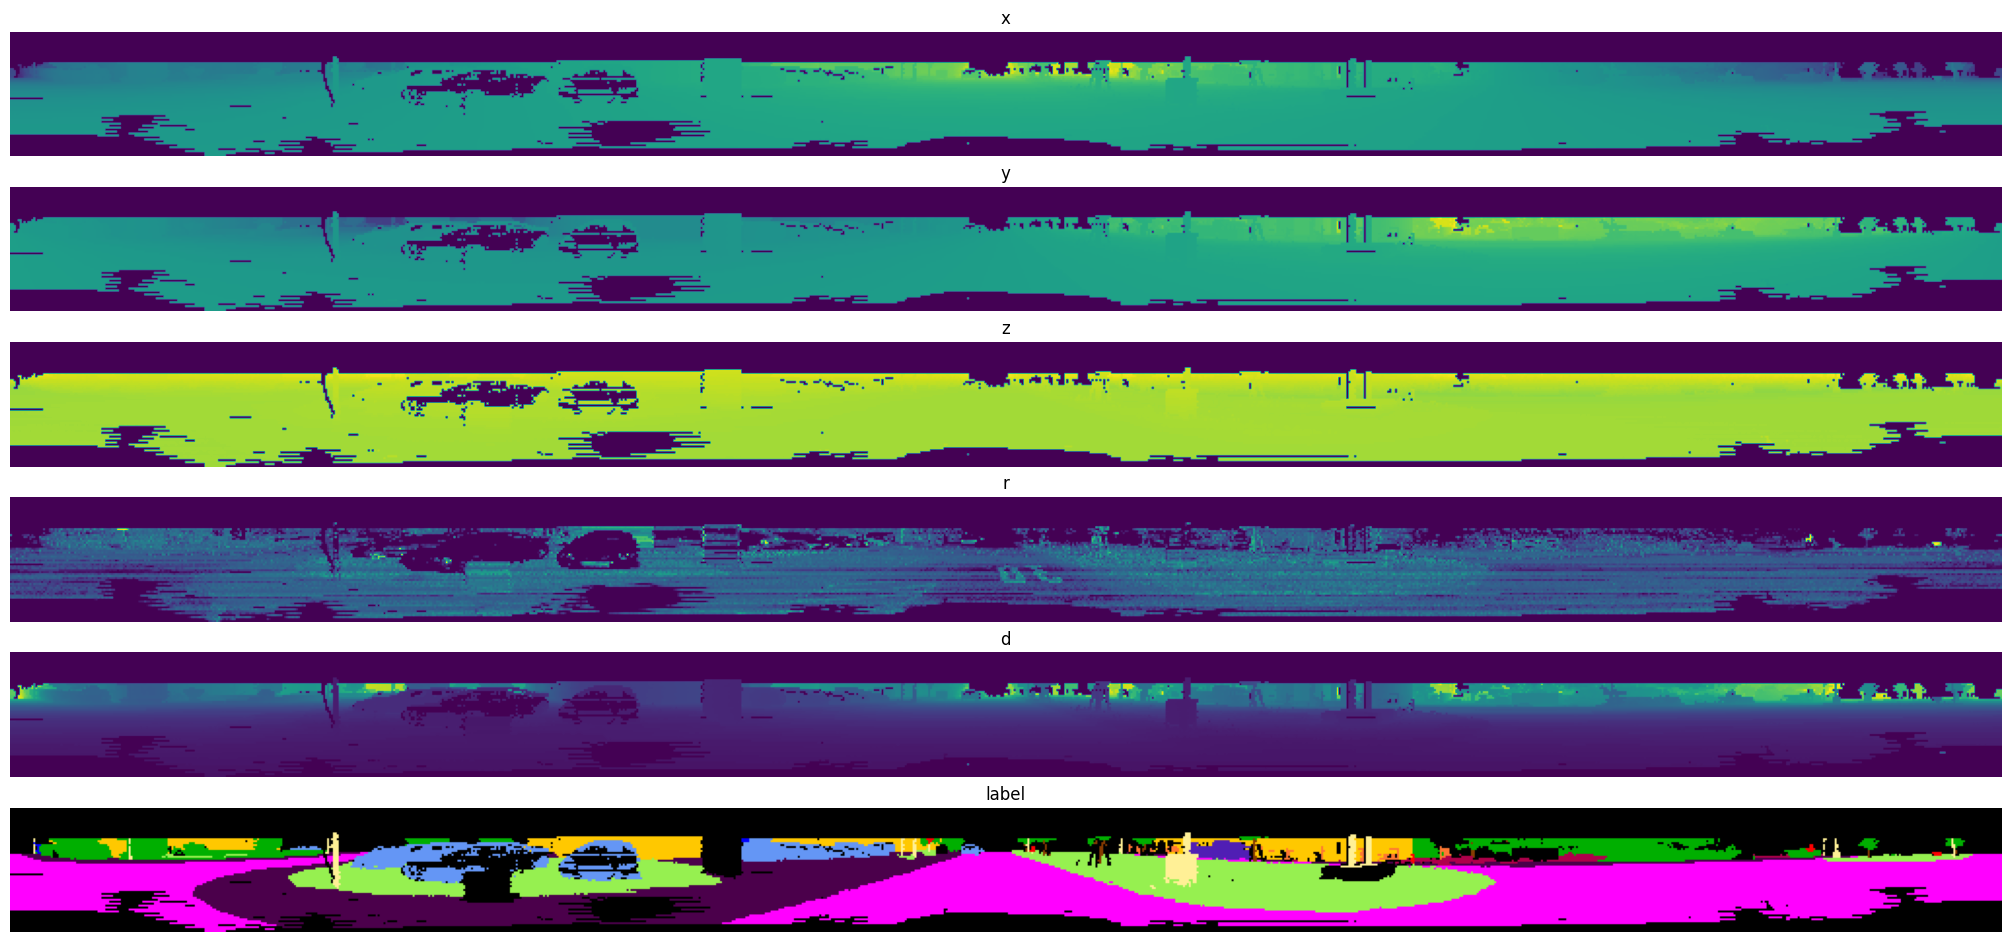

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
img, label, _ = ds[128]

plot_projections(img, label)

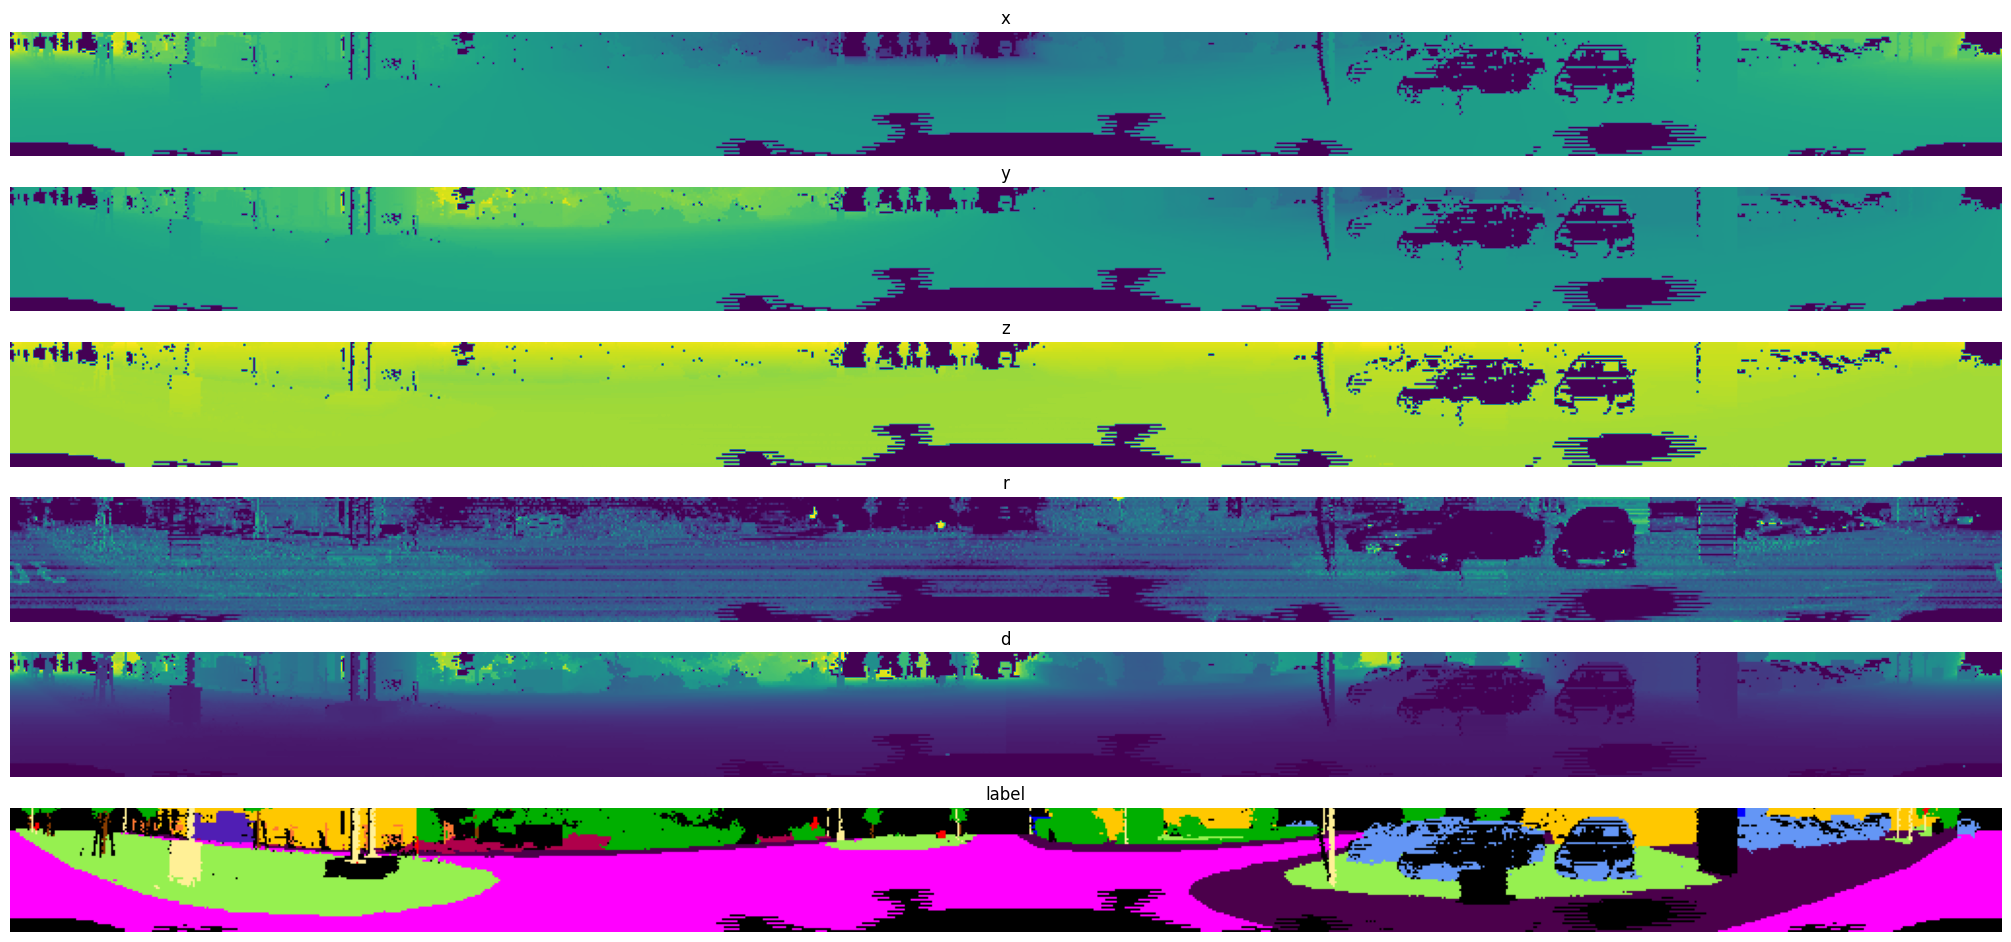

In [ ]:
#| eval: false
proj = UnfoldingProjection(W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
img, label, _ = ds[128]

plot_projections(img, label)

In the next cell, we can see how long it takes on average to sample an item from this dataset class.

In [ ]:
#| eval: false
%timeit img, label, _ = ds[0]

15.6 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| export
class ProjectionToTensorTransform(nn.Module):
    "Pytorch transform that converts the projections from np.array to torch.tensor. It also changes the frame image format from (H, W, C) to (C, H, W)."
    def forward(self, frame_img, label_img, mask_img):
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        label_img = torch.from_numpy(label_img)
        mask_img = torch.from_numpy(mask_img)
        return frame_img, label_img, mask_img

In order to use the dataset to train pytorch models, it is necessary to transform the data from numpy arrays to torch tensors. Also, for the frame images, it is necessary to transpose (or permute in torch lingo) its axis from *channels last* (H, W, C) to *channels first* (C, H, W).

Here is an example on how to use it with the scan unfolding projection:

In [ ]:
#| eval: false
proj = UnfoldingProjection(W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorTransform(),
])
ds.set_transform(tfms)
img, label, mask = ds[0]
print(img.shape, img.type())
print(label.shape, label.type())
print(mask.shape, mask.type())

torch.Size([5, 64, 1024]) torch.FloatTensor
torch.Size([64, 1024]) torch.LongTensor
torch.Size([64, 1024]) torch.BoolTensor


Here is an example on how to combine the classes above to implement a *torch.utils.data.Dataloader* that iterates on batches of frame images, labels and masks:

In [ ]:
#| eval: false
from torch.utils.data import DataLoader

In [ ]:
#| eval: false
bs = 10
dl = DataLoader(ds, bs)
for batch in dl:
    img, label, mask = batch
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([10, 5, 64, 1024])
Shape of label 	 [N, H, W]: 	 torch.Size([10, 64, 1024])
Shape of mask 	 [N, H, W]: 	 torch.Size([10, 64, 1024])


## Remapping the labels

The paper [MVLidarNet: Real-Time Multi-Class Scene Understanding for Autonomous Driving Using Multiple Views](https://arxiv.org/pdf/2006.05518) proposes a different mapping of the labels for training than the one proposed by the yaml in the semantic-kitti-api. They only use the following 7 classes:

- car
- truck
- person/pedestrians
- cyclist
- road
- sidewalk

From the original yaml file, we can use the following remapping rules dictionary and the method *learning.remap* from the dataset to apply the remapping:

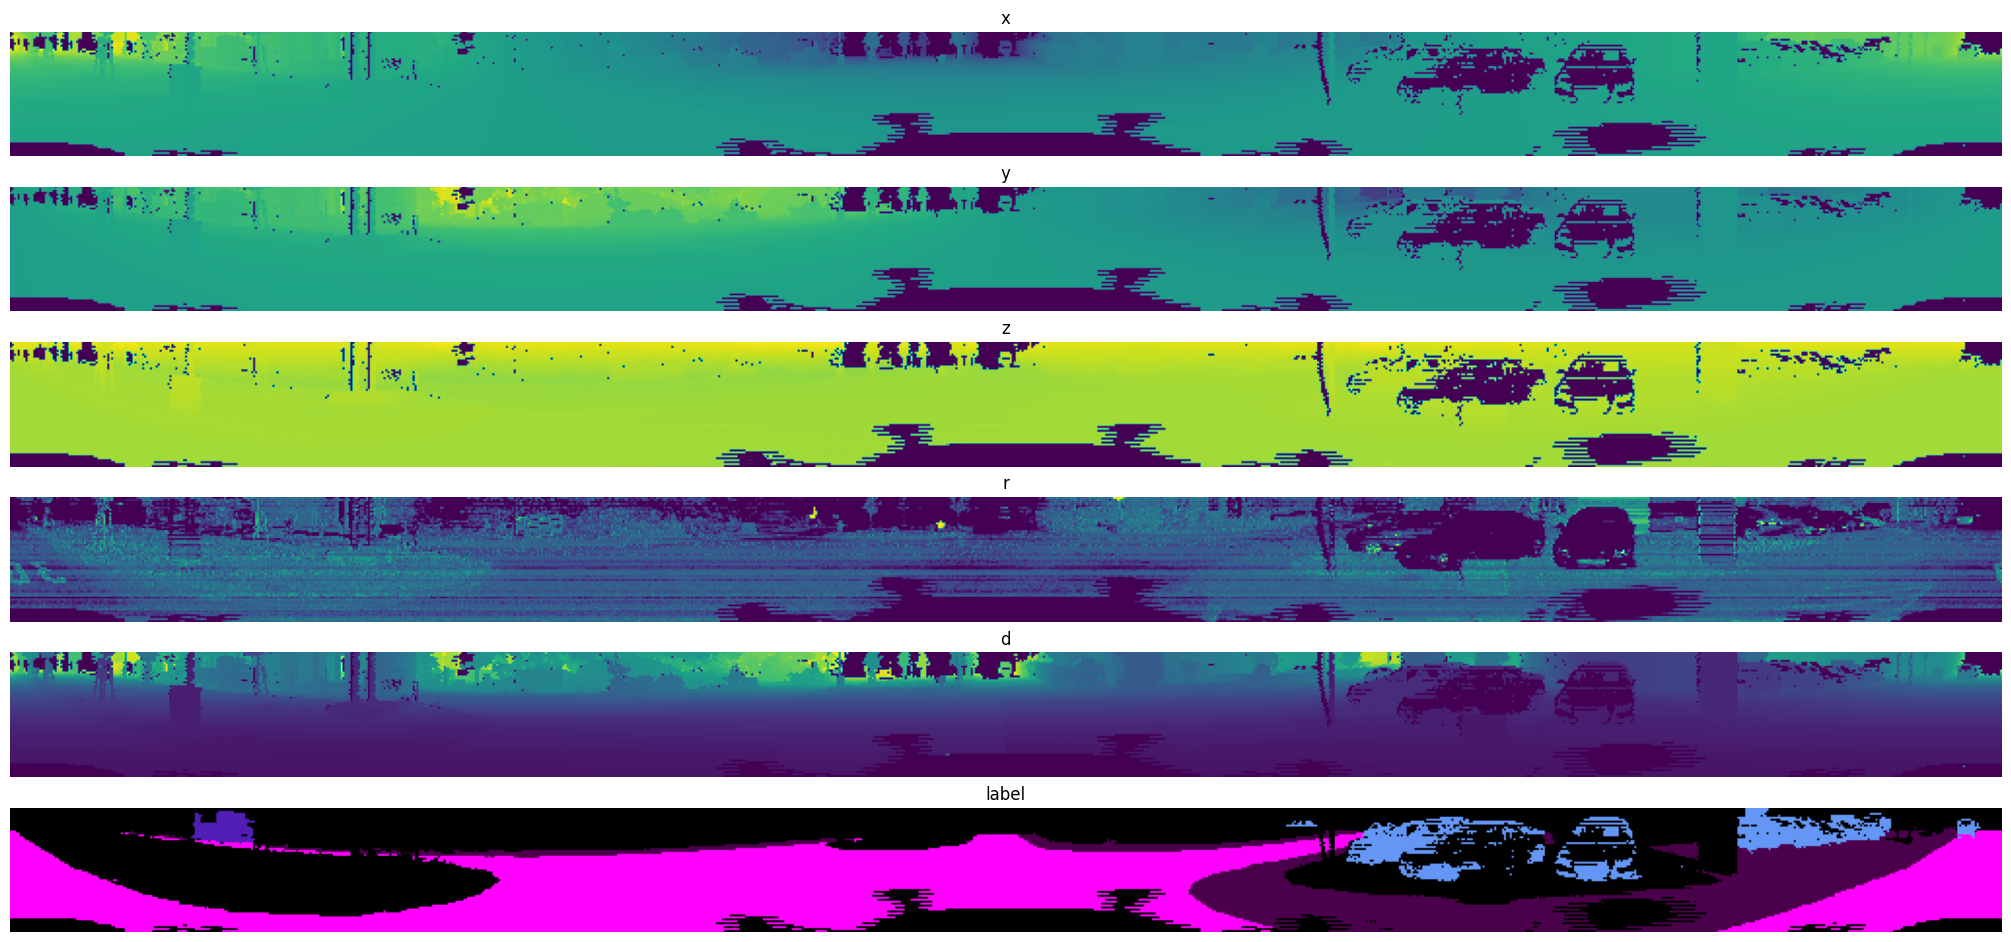

In [ ]:
#| eval: false
remapping_rules = {
    1: 1,
    4: 2,
    6: 3,
    7: 4,
    2: 4,
    9: 5,
    11: 6
}
ds.learning_remap(remapping_rules)

tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
img, label, _ = ds[128]

plot_projections(img, label)

## Exploratory Data Analysis (EDA)

In [ ]:
#| eval: false
ds = SemanticKITTIDataset(data_path)
f_lens = []
for f, l, m in ds:
    f_lens += [len(f)]
f_lens = np.array(f_lens)

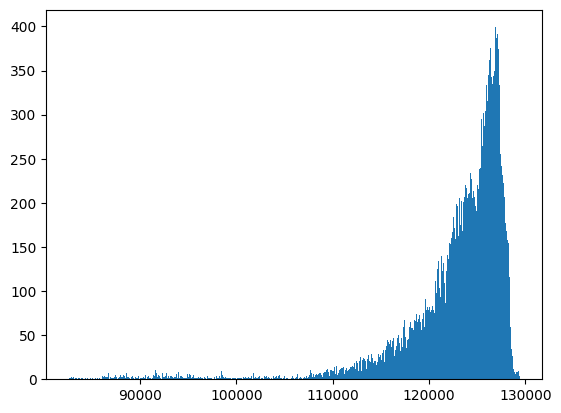

In [ ]:
#| eval: false
plt.hist(f_lens, 500);

22461


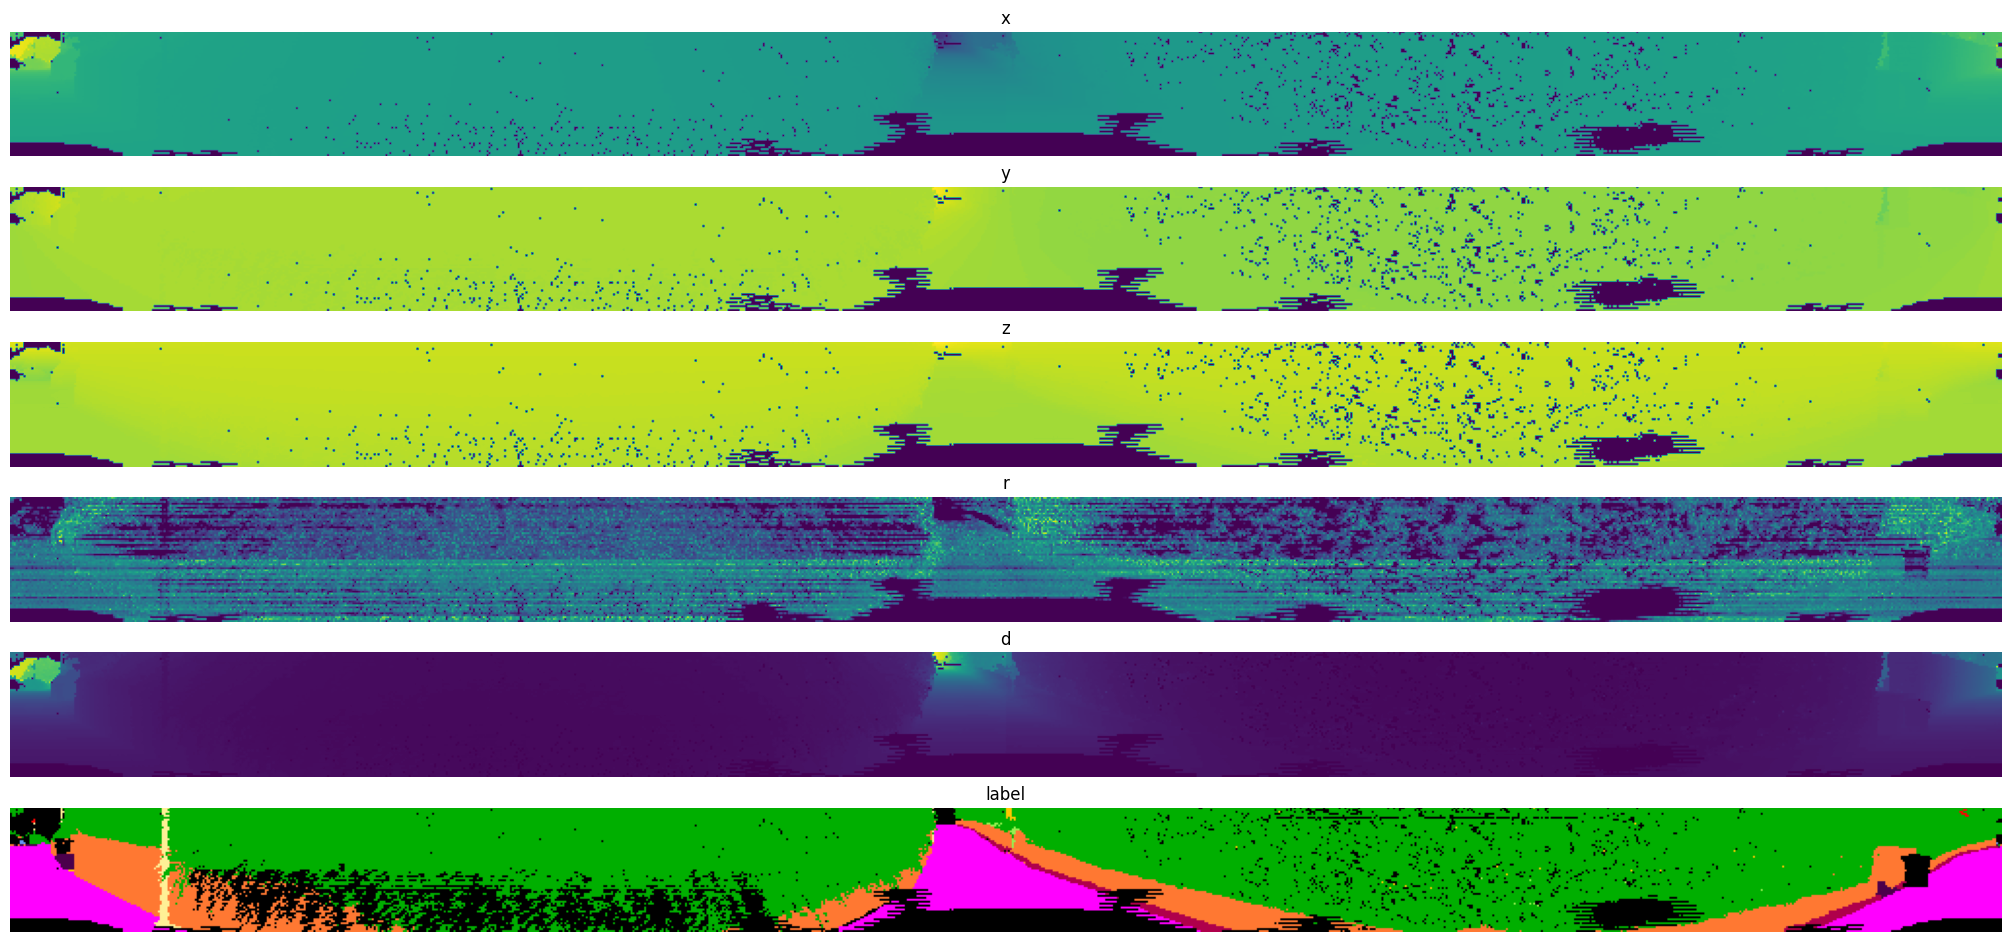

In [ ]:
#| eval: false
idxs = np.arange(len(ds))
idx = idxs[f_lens > 129300][0]
print(idx)

proj = UnfoldingProjection(W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
img, label, _ = ds[idx]

plot_projections(img, label)

## LightningDataModules for benchmarking

When benchmarking different semantic segmentation algorithms, the following LightningDataModule should be used.

In [ ]:
#| export
class SemanticSegmentationLDM(LightningDataModule):
    "Lightning DataModule to facilitate reproducibility of experiments."
    def __init__(self, 
                 proj_style='unfold',
                 proj_kargs={'W': 512, 'H': 64},
                 remapping_rules=None,
                 train_batch_size=8, 
                 eval_batch_size=16,
                 num_workers=8
                ):
        super().__init__()

        proj_class = {
        'unfold': UnfoldingProjection,
        'spherical': SphericalProjection
        }
        assert proj_style in proj_class.keys()
        self.proj = proj_class[proj_style](**proj_kargs)
        self.remapping_rules = remapping_rules
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.num_workers = num_workers
    
    def setup(self, stage: str):
        data_path = '/workspace/data'
        tfms = v2.Compose([
            ProjectionTransform(self.proj),
            ProjectionToTensorTransform(),
        ])
        ds = SemanticKITTIDataset(data_path, is_train=(stage == "fit"), transform=tfms)
        if self.remapping_rules:
            ds.learning_remap(self.remapping_rules)
        if not hasattr(self, 'viz_tfm'):
            self.viz_tfm = ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np)
        
        if stage == "fit":
            self.ds_train, self.ds_val = random_split(
                ds, [0.7, 0.3], generator=torch.Generator().manual_seed(42)
            )
        if stage == "test":
            self.ds_test = ds
        if stage == "predict":
            self.ds_predict = ds
            

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.train_batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.ds_predict, batch_size=self.eval_batch_size, num_workers=self.num_workers)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()